### Imports

In [1]:
import math
import random
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, classification_report

import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import TextClassificationPipeline
from datasets import Dataset, DatasetDict, Features, ClassLabel, Value

device = torch.device("cpu")

# Set folder where models will be saved
# dir_models = Path('models') # Relative path
dir_models = Path(r'C:\Users\rldek\Mijn Drive (r.l.dekkers@tilburguniversity.edu)\Thesis\Code\thesis-msc-data-science\models')
dir_data = Path(r'C:\Users\rldek\Mijn Drive (r.l.dekkers@tilburguniversity.edu)\Thesis\Code\thesis-msc-data-science\data')

### Model configs

In [2]:
models = {
    'bert_base_full': { # Base BERT model on full original dataset, reproduced from Luo et al.
        'output_name': 'bert_base_full',
        'ckpt': "google-bert/bert-base-uncased",
        'context_type': None,
        'dataset_type': 'orig',
    },   
    'bert_base_reduc': { # Base BERT model on reduced dataset (corresponding to samples available in augm. dataset)
        'output_name': 'bert_base_reduc',
        'ckpt': "google-bert/bert-base-uncased",
        'context_type': None,
        'dataset_type': 'reduc',
    },  
    'bert_aug_before': { # Model on augmented dataset, using '[CLS] context [SEP] sentence [SEP]' structure
        'output_name': 'bert_aug_before',
        'ckpt': "google-bert/bert-base-uncased",
        'context_type': 'before',
        'dataset_type': 'aug_before',
    },  
    'bert_aug_after': { # Model on augmented dataset, using '[CLS] sentence [SEP] context [SEP]' structure
        'output_name': 'bert_aug_after',
        'ckpt': "google-bert/bert-base-uncased",
        'context_type': 'after',
        'dataset_type': 'aug_after',
    },   
    'droberta_base': { # Base distilRoBERTa model to compare against Climate-model
        'output_name': 'droberta_base',
        'ckpt': "distilbert/distilroberta-base",
        'context_type': None,
        'dataset_type': 'orig',
    },      
    'droberta_climate': {
        'output_name': 'droberta_climate',
        'ckpt': "climatebert/distilroberta-base-climate-f",
        'context_type': None,
        'dataset_type': 'orig',
    },
}

model_names = [
    'bert_base_full',   # Base BERT model on full original dataset, reproduced from Luo et al.
    'bert_base_reduc',  # Base BERT model on reduced dataset (corresponding to samples available in augm. dataset)
    'bert_aug_before',  # Model on augmented dataset, using '[CLS] context [SEP] sentence [SEP]' structure
    'bert_aug_after',   # Model on augmented dataset, using '[CLS] sentence [SEP] context [SEP]' structure
    'droberta_base',    # Base distilRoBERTa model to compare against Climate-model
    'droberta_climate', # Climate model on full original dataset
]

ckpts = {
    'bert_base_full': "google-bert/bert-base-uncased",
    'bert_base_reduc': "google-bert/bert-base-uncased",
    'bert_aug_before': "google-bert/bert-base-uncased",
    'bert_aug_after': "google-bert/bert-base-uncased",
    'droberta_base': "distilbert/distilroberta-base",
    'droberta_climate': "climatebert/distilroberta-base-climate-f",
}



### Data selection and partitioning

In [3]:
data_file = dir_data / 'articles.pkl'

# Import and modify pandas dataframe
data_df = pd.read_pickle(data_file)

# Construct multiple context types
def get_context(row: pd.Series, context_type: str):
    if context_type == 'before':
        return f"{row['title']} : {row['sent-5']} {row['sent-4']} {row['sent-3']} {row['sent-2']} {row['sent-1']} {row['sent0']}"
    elif context_type == 'after':
        return f"{row['sent0']} {row['sent+1']} {row['sent+2']} {row['sent+3']} {row['sent+4']} {row['sent+5']}"
    else:
        return ''

for context_type in ['context_before', 'context_after']:
    data_df[context_type] = data_df.apply(lambda row: get_context(row, context_type), axis=1)

# Split train-test
data_df_train = data_df[data_df['in_held_out_test'] == False].reset_index(drop=True)
data_df_test = data_df[data_df['in_held_out_test'] == True].reset_index(drop=True)  # test_set defined by Luo et al. and used for human baseline

# Select reduced size dataset (based on available samples for augmented dataset)
data_df_train_reduc = data_df_train[data_df_train['ok'] == True].reset_index(drop=True)
data_df_test_reduc = data_df_test[data_df_test['ok'] == True].reset_index(drop=True)

# Change dataframe to Transformers dataset type

# Define dataset features
features_dict = {
    'orig': Features({'sentence': Value('string'),
                      'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'reduc': Features({'sentence': Value('string'),
                      'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'aug_before': Features({'sentence': Value('string'),
                            'context_before': Value('string'),
                            'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'aug_after': Features({'sentence': Value('string'),
                            'context_after': Value('string'),
                            'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
}

# Create dataset variants
datasets = {
    'orig': DatasetDict({
        'train': Dataset.from_pandas(data_df_train[['label', 'sentence']], features=features_dict['orig']),
        'test': Dataset.from_pandas(data_df_test[['label', 'sentence']], features=features_dict['orig'])
    }),
    'reduc': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'sentence']], features=features_dict['reduc']),
        'test': Dataset.from_pandas(data_df_test_reduc[['label', 'sentence']], features=features_dict['reduc'])
    }),
    'aug_before': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'context_before', 'sentence']], features=features_dict['aug_before']),
        'test': Dataset.from_pandas(data_df_test_reduc[['label', 'context_before', 'sentence']], features=features_dict['aug_before'])
    }),
    'aug_after': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'context_after', 'sentence']], features=features_dict['aug_after']),
        'test': Dataset.from_pandas(data_df_test_reduc[['label', 'context_after', 'sentence']], features=features_dict['aug_after'])
    }),
}

In [5]:
# This comparison shows that the proportion of test samples in the reduced dataset is similar, which is good.
print(data_df['in_held_out_test'].value_counts(normalize=True))
print(data_df[data_df['ok'] == True]['in_held_out_test'].value_counts(normalize=True))

in_held_out_test
False    0.902439
True     0.097561
Name: proportion, dtype: float64
in_held_out_test
False    0.900592
True     0.099408
Name: proportion, dtype: float64


### Tokenization

In [ ]:
# Luo et al. note using a max_seq_length=256 (but don't expalain why) in Appendix H (p. 3312). They truncate all characters after it.
# can be found in...
# model_base.config.max_position_embeddings (default = 512)

In [6]:
# Get tokenizers
for model, config in models.items():
    models[model]['tokenizer'] = AutoTokenizer.from_pretrained(config['ckpt'])

def tokenize(batch, tokenizer, context=None):
    if context == None:
        return tokenizer(batch["sentence"], padding=True, truncation=True)
    elif context =='before':
        return tokenizer(text=batch["context_before"], text_pair=batch["sentence"], padding=True, truncation=True)
    elif context == 'after':
        return tokenizer(text=batch["sentence"], text_pair=batch["context_after"], padding=True, truncation=True)

# Tokenize
for model, config in models.items():
    models[model]['dataset_enc'] = datasets[config['dataset_type']].map(lambda batch: tokenize(batch, config['tokenizer'], config['context_type']), batched=True, batch_size=None)

# Encode data for PyTorch
for model, config in models.items():
    if config['context_type'] == 'before' or config['context_type'] == 'after':
        models[model]['dataset_enc'].set_format("torch", columns = ["input_ids", "attention_mask", "label", "token_type_ids"])
    else:
        models[model]['dataset_enc'].set_format("torch", columns = ["input_ids", "attention_mask", "label"])

c:\Users\rldek\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

### Training

##### Random seed

In [ ]:
# for reproducability

def set_deterministic(seed: int):
    """Set random seed and disable deterministic algorithms for reproducability of results"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms()

set_deterministic()

##### Set-up

In [5]:
"""
The following hyperparameter values were matched to Luo et al.'s best grid search results:
- 7 training epochs
- learning rate = 2e-5
- batch size = 16
- optimizer: AdamW (Adam with decoupled weight decay regularization)
    - epsilon = 1e-6
- learning rate scheduler: 
    - linearly decaying from 2e-5 to 0
- loss function: CrossEntropyLoss
- weight decay = 0
- gradient accumulation steps = 1    
"""

# Define metrics for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return { "accuracy": accuracy_score(labels, preds),
             "f1": f1_score(labels, preds, average="macro")}

# Define label dictionary for HuggingFace model config.json
label_names = datasets['orig']['train'].features['label'].names
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {label: i for i, label in enumerate(label_names)}

# TODO: change HuggingFace model card

def get_training_args(output_name: str) -> TrainingArguments:
    """
    Get HuggingFace TrainingArgs object. 'output_name' is used for output_dir
    """
    return TrainingArguments(
        output_dir = dir_models / {output_name},
        num_train_epochs = 7,
        learning_rate = 2e-5,
        per_device_train_batch_size = 16,
        per_device_eval_batch_size = 16,
        adam_epsilon = 1e-6,
        warmup_steps = 0,
        evaluation_strategy = 'epoch',
        logging_strategy = 'epoch',
        save_strategy = 'epoch',
        save_total_limit = 5,
        metric_for_best_model = 'f1',
        load_best_model_at_end = True)

def init_trainer(model, args: TrainingArguments, dataset: DatasetDict, tokenizer):
    return Trainer(model=model, args=args,
                   compute_metrics=compute_metrics,
                   train_dataset = dataset['train'],
                   eval_dataset = dataset['test'],
                   tokenizer=tokenizer)


def train_model(model_name: str) -> None:
    """Train model according to specified configuration in 'models' dict. """
    config = models[model_name]

    config['model'] = AutoModelForSequenceClassification.from_pretrained(config['ckpt'], num_labels=3, id2label=id2label, label2id=label2id).to(device)
    config['train_args'] = get_training_args(config['output_name'])
    config['trainer'] = init_trainer(config['model'], config['train_args'], config['dataset_enc'], config['tokenizer'])
    config['trainer'].train()

##### Train multiple

In [ ]:
for model_name in models.keys():
    train_model(model_name)

##### BERT base full

In [ ]:
train_model('bert_base_full')

# config = models['bert_base_full']

# config['model'] = AutoModelForSequenceClassification.from_pretrained(config['ckpt'], num_labels=3).to(device)
# config['train_args'] = get_training_args(config['output_name'])
# config['trainer'] = init_trainer(config['model'], config['train_args'], config['dataset_enc'], config['tokenizer'])
# config['trainer'].train()

##### BERT base reduced

In [ ]:
config = models['bert_base_reduc']

config['model'] = AutoModelForSequenceClassification.from_pretrained(config['ckpt'], num_labels=3).to(device)
config['train_args'] = get_training_args(config['output_name'])
config['trainer'] = init_trainer(config['model'], config['train_args'], config['dataset_enc'], config['tokenizer'])
config['trainer'].train()

##### Augmented before

In [ ]:
config = models['bert_aug_before']

config['model'] = AutoModelForSequenceClassification.from_pretrained(config['ckpt'], num_labels=3).to(device)
config['train_args'] = get_training_args(config['output_name'])
config['trainer'] = init_trainer(config['model'], config['train_args'], config['dataset_enc'], config['tokenizer'])
config['trainer'].train()

##### Augmented after

In [ ]:
config = models['bert_aug_after']

config['model'] = AutoModelForSequenceClassification.from_pretrained(config['ckpt'], num_labels=3).to(device)
config['train_args'] = get_training_args(config['output_name'])
config['trainer'] = init_trainer(config['model'], config['train_args'], config['dataset_enc'], config['tokenizer'])
config['trainer'].train()

##### DistilRoBERTa_base

In [11]:
config = models['droberta_base']

config['model'] = AutoModelForSequenceClassification.from_pretrained(config['ckpt'], num_labels=3).to(device)
config['train_args'] = get_training_args(config['output_name'])
config['trainer'] = init_trainer(config['model'], config['train_args'], config['dataset_enc'], config['tokenizer'])
config['trainer'].train()

c:\Users\rldek\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/812 [00:00<?, ?it/s]

{'loss': 0.933, 'grad_norm': 11.955500602722168, 'learning_rate': 1.7142857142857142e-05, 'epoch': 1.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7450017333030701, 'eval_accuracy': 0.675, 'eval_f1': 0.6549990061617968, 'eval_runtime': 4.8388, 'eval_samples_per_second': 41.332, 'eval_steps_per_second': 2.687, 'epoch': 1.0}
{'loss': 0.674, 'grad_norm': 16.982330322265625, 'learning_rate': 1.4285714285714287e-05, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.6415913105010986, 'eval_accuracy': 0.745, 'eval_f1': 0.7420564591044116, 'eval_runtime': 4.8491, 'eval_samples_per_second': 41.245, 'eval_steps_per_second': 2.681, 'epoch': 2.0}
{'loss': 0.4863, 'grad_norm': 29.642160415649414, 'learning_rate': 1.1428571428571429e-05, 'epoch': 3.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.6354121565818787, 'eval_accuracy': 0.785, 'eval_f1': 0.7916177560107984, 'eval_runtime': 4.8634, 'eval_samples_per_second': 41.124, 'eval_steps_per_second': 2.673, 'epoch': 3.0}
{'loss': 0.3503, 'grad_norm': 21.270483016967773, 'learning_rate': 8.571428571428571e-06, 'epoch': 4.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.6652915477752686, 'eval_accuracy': 0.755, 'eval_f1': 0.7606241182937244, 'eval_runtime': 4.7538, 'eval_samples_per_second': 42.071, 'eval_steps_per_second': 2.735, 'epoch': 4.0}
{'loss': 0.2483, 'grad_norm': 29.48572540283203, 'learning_rate': 5.7142857142857145e-06, 'epoch': 5.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7476350665092468, 'eval_accuracy': 0.75, 'eval_f1': 0.7432872503840245, 'eval_runtime': 5.0991, 'eval_samples_per_second': 39.222, 'eval_steps_per_second': 2.549, 'epoch': 5.0}
{'loss': 0.1757, 'grad_norm': 38.85407257080078, 'learning_rate': 2.8571428571428573e-06, 'epoch': 6.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.8206955194473267, 'eval_accuracy': 0.745, 'eval_f1': 0.7449107120305118, 'eval_runtime': 4.7233, 'eval_samples_per_second': 42.343, 'eval_steps_per_second': 2.752, 'epoch': 6.0}
{'loss': 0.1295, 'grad_norm': 2.5823662281036377, 'learning_rate': 0.0, 'epoch': 7.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.814454197883606, 'eval_accuracy': 0.76, 'eval_f1': 0.765670644360883, 'eval_runtime': 4.6108, 'eval_samples_per_second': 43.377, 'eval_steps_per_second': 2.819, 'epoch': 7.0}
{'train_runtime': 1431.1701, 'train_samples_per_second': 9.049, 'train_steps_per_second': 0.567, 'train_loss': 0.42814570224931087, 'epoch': 7.0}


TrainOutput(global_step=812, training_loss=0.42814570224931087, metrics={'train_runtime': 1431.1701, 'train_samples_per_second': 9.049, 'train_steps_per_second': 0.567, 'total_flos': 241239853864800.0, 'train_loss': 0.42814570224931087, 'epoch': 7.0})

##### DistilRoBERTa_Climate

In [ ]:
config = models['droberta_climate']

config['model'] = AutoModelForSequenceClassification.from_pretrained(config['ckpt'], num_labels=3).to(device)
config['train_args'] = get_training_args(config['output_name'])
config['trainer'] = init_trainer(config['model'], config['train_args'], config['dataset_enc'], config['tokenizer'])
config['trainer'].train()

# on may 15th, best epoch was 5 (checkpoint-580)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.939500,0.757471,0.625000,0.598745
2,0.648500,0.628923,0.745000,0.742921
3,0.467800,0.622958,0.760000,0.759140
4,0.331200,0.646882,0.760000,0.759107
5,0.226400,0.702919,0.770000,0.769499
6,0.167800,0.784633,0.765000,0.763519


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.939500,0.757471,0.625000,0.598745
2,0.648500,0.628923,0.745000,0.742921
3,0.467800,0.622958,0.760000,0.759140
4,0.331200,0.646882,0.760000,0.759107
5,0.226400,0.702919,0.770000,0.769499
6,0.167800,0.784633,0.765000,0.763519
7,0.123700,0.803689,0.760000,0.758683


### Evaluation

##### Retrieve model

In [7]:
# Specify model
model_name = 'bert_base_full'
config = models[model_name]

# Calculate total steps (to find folder)
n_samples = len(config['dataset_enc']['train'])
n_epochs = 7
batch_size = 16

steps_per_epoch = math.ceil(n_samples / batch_size)
total_steps = steps_per_epoch * n_epochs

# Obtain folder path
folder_path = dir_models / config['output_name'] / f'checkpoint-{total_steps}'

if not folder_path.exists():
    raise FileNotFoundError("Folder does not exist. Perhaps the location is incorrect, or the model was not trained, or the checkpoint-step number is incorrect?")

model_local = AutoModelForSequenceClassification.from_pretrained(folder_path, num_labels=3)
tokenizer_local = AutoTokenizer.from_pretrained(folder_path)

##### Evaluate model

In [59]:
pipe = TextClassificationPipeline(model=model_local, tokenizer=tokenizer_local)

preds = pipe(config['dataset_enc']['test']['sentence'])

y_pred = np.array([label2id[pred['label']] for pred in preds])
y_true = np.array(config['dataset_enc']['test']['label'])

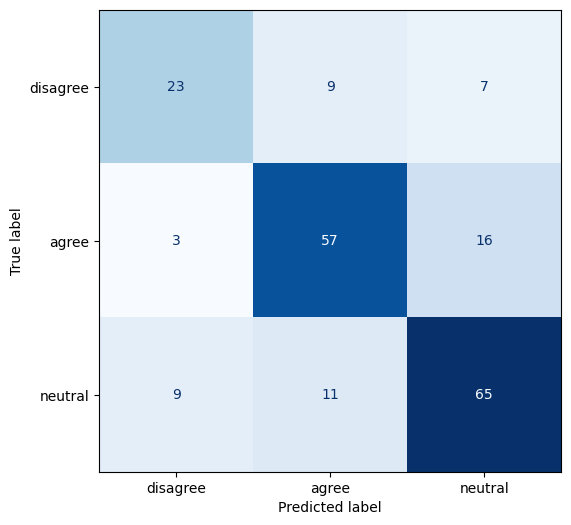

              precision    recall  f1-score   support

    disagree       0.66      0.59      0.62        39
       agree       0.74      0.75      0.75        76
     neutral       0.74      0.76      0.75        85

    accuracy                           0.73       200
   macro avg       0.71      0.70      0.71       200
weighted avg       0.72      0.72      0.72       200



In [60]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

labels = list(label2id.keys())

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax, colorbar=False)

plt.show()

print(classification_report(y_true, y_pred, target_names=labels))

In [64]:
import json
log_path = folder_path / 'trainer_state.json'
if not log_path.exists():
    raise FileNotFoundError("'trainer_state.json' not found.")

with open(log_path) as file:
    log = json.load(file)

In [70]:
log_eval_f1 = {entry['epoch']: entry['eval_f1'] for entry in log['log_history'] if 'eval_f1' in entry}
log_eval_loss = {entry['epoch']: entry['eval_loss'] for entry in log['log_history'] if 'eval_loss' in entry}
log_train_loss = {entry['epoch']: entry['loss'] for entry in log['log_history'] if 'loss' in entry}

### Push model to hub

##### Push to hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer_base_bert.push_to_hub(commit_message="...")

### Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### PyTorch implementation

##### Setup

In [32]:
import torch
from torch.utils.data import DataLoader, RandomSampler
from torch.nn import CrossEntropyLoss
from tqdm import tqdm, trange
from transformers import AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(ckpts['base_full'], num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
import math
n_samples = len(models['bert_base_reduc']['dataset_enc']['train'])
n_epochs
batch_size = 16

steps_per_epoch = math.ceil(n_samples / batch_size)
total_steps = steps_per_epoch * n_epochs

672

In [33]:
# $ dollar symbol is matched in my own code above

train_sampler = RandomSampler(models['bert_base_full']['dataset_enc']['train'])
train_dataloader = DataLoader(models['bert_base_full']['dataset_enc']['train'], sampler=train_sampler, batch_size=16)

grad_accum_steps = 1
n_epochs = 7
t_total = len(train_dataloader) // grad_accum_steps * n_epochs

print(f"t_total: {t_total}")
print(f"update steps per epoch (in Transformers Trainer): {len(train_dataloader) // grad_accum_steps}")

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-6)                                              # $
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0, num_training_steps=t_total) # $

# display learning rate schedule
lrs=[]
for i in range(t_total):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()
plt.plot(lrs);

t_total: 812
update steps per epoch (in Transformers Trainer): 116


AttributeError: 'str' object has no attribute 'parameters'

##### Training

In [36]:
for _ in trange(0, 2, desc="Epoch"):

    for step, batch in enumerate(tqdm(train_dataloader, desc="Iter")):
        print(step)
        pass

Iter: 100%|██████████| 116/116 [00:00<00:00, 1684.11it/s]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


Epoch: 100%|██████████| 2/2 [00:00<00:00, 14.33it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


In [ ]:
# test code
import time

# Get model
# if model not trained yet...
# model = ..from_pretrained(...)
# if model already partially trained
# model = ... from local checkpoint


tr_loss = 0.0
epochs_trained = 0
model.zero_grad()

# Iterate through epochs
for _ in trange(epochs_trained, n_epochs, desc="Epoch"):

    # Iterate through batches in epoch
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):

        # Set model to training mode
        model.train()

        # # Gather inputs
        # inputs = {"input_ids": batch[...],
        #           "attention_mask": batch[...],
        #           "token_type_ids": batch[...]}
        # labels = batch[...]

        outputs = model(**inputs)
        logits = outputs[0]

        # TODO: the loss calculation is still un-weighted
        loss_function = CrossEntropyLoss()
        num_labels = 3 # TODO: can I get this from 'labels'?
        loss = loss_function(logits.view(-1, num_labels), labels.view(-1))

        # loss_function = CrossEntropyLoss(reduction='none')
        # num_labels = 3
        # instance_weights = batch[...].to(device)
        # loss = loss_function(logits.view(-1, num_labels), labels.view(-1))
        # loss = (loss * instance_weights).mean()

        loss.backward() # Calculate gradients

        tr_loss += loss.item()





Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Iteration:   0%|          | 0/116 [00:00<?, ?it/s]


dict_keys(['label', 'input_ids', 'attention_mask'])




Iteration:   1%|          | 1/116 [00:02<03:50,  2.01s/it]


dict_keys(['label', 'input_ids', 'attention_mask'])




Iteration:   2%|▏         | 2/116 [00:04<03:49,  2.01s/it]


dict_keys(['label', 'input_ids', 'attention_mask'])




Iteration:   3%|▎         | 3/116 [00:06<03:47,  2.02s/it]


dict_keys(['label', 'input_ids', 'attention_mask'])




Iteration:   3%|▎         | 4/116 [00:08<03:46,  2.02s/it]


dict_keys(['label', 'input_ids', 'attention_mask'])


Epoch:   0%|          | 0/7 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def train():

    logging_steps = 500 # default value in Luo et al. -> log  every X updates steps
    save_steps = 500    # default value in Luo et al. -> save every X updates steps
    evaluate_during_training = 0

    global_step = 0   # Where is this gathered?
    epochs_trained = 0
    steps_trained_in_current_epoch = 0  # what is this for?

    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(epochs_trained, int(n_epochs), desc="Epoch")

    # def set_seed(seed):
    #     random.seed(seed)
    #     np.random.seed(seed)
    #     torch.manual_seed(seed)
    # set_seed(seed)

    for _ in train_iterator:

        epoch_iterator = tqdm(train_dataloader, desc="Iteration")

        for step, batch in enumerate(epoch_iterator):

            model.train() # set to training mode


            # TODO: make data index format compatible. below code from Y. Luo et al
            labels = batch[3].to(device)
            instance_weights = batch[4].to(device)
            batch = tuple(t.to(device) for t in batch)
            inputs = { "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2]}
            outputs = model(**inputs)
            logits = outputs[0]

            loss_function = CrossEntropyLoss(reduction='none')  # default reduction='mean' (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

            # TODO: check if data format matches
            num_labels = 3
            loss = loss_function(logits.view(-1, num_labels), labels.view(-1))

            # instance weights should be part of inputs
            instance_weights = batch[4].to(device)
            loss = (loss * instance_weights).mean() # ❗ TODO


            loss.backward()  # calculate gradients

            tr_loss += loss.item()

            if (step + 1) % 1 == 0: # ??? what does this mean?
                torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)  # &

                optimizer.step()
                scheduler.step()
                model.zero_grad()

                global_step += 1

                # # TODO: check this code block
                # # log
                # if logging_steps > 0 and global_step % logging_steps == 0:


                #     logs = {}
                #     if evaluate_during_training:
                #         # results = evaluate()  # TODO! evaluate() function is implemented in source code
                #         for k, v in results.items():
                #             eval_key = f"eval_{key}"
                #             logs[eval_key] = v

                #     loss_scalar = (tr_loss - logging_loss) / logging_steps
                #     lr_scalar = scheduler.get_lr()[0]
                #     logs["learning_rate"] = lr_scalar
                #     logs["loss"] = loss_scalar
                #     logging_loss = tr_loss

                #     # for k, v in logs.items():
                #     #     log_file.write(f"{k}\t{v}\t{global_step}\n")


                # save checkpoint
                if save_steps > 0 and global_step % save_steps == 0:

                    # TODO: check if output_dir + file is specified correctly
                    output_dir = "models"

                    model.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir) # why does Luo et al. save this? does the vocab update?

                    torch.save(optimizer.state_dict(), output_dir+"/optimizer.pt")
                    torch.save(scheduler.state_dict(), output_dir+"/scheduler.pt")

    #log_file.close()  # ! log file never opened in the first place

    return global_step, tr_loss / global_step


